In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import torch
from IPython.display import Audio, display
from torch import Tensor
from torch.utils.data import DataLoader

from src.dataset import SignalTrainDataset, download_signal_train_dataset_to
from src.model import S4ConditionalSideChainModel
from src.parameter import ConditionalTaskParameter
from src.utils import get_tensor_device, set_random_seed_to

# S4 Hyper-conditioning Dynamic Range Compressor Model Evaluation

This Jupyter Notebook contains routine to evaluate a trained S4 DRC model with hyper-conditioning.

Edit and execute the code in the [Preparatory Work](#preparatory-work) section first to load the model,
and then execude the code in the rest of the section to evaluate each individual metrics.

Each individual evaluation task is wrapped in a function to prevent variables going global,
and neither any function alters the file system.

## <a id="preparatory-work">Preparatory Work</a>

Edit the following global constant to locate the model to be evaluated.

If the model is trained properly using my given script, you don't need to edit any other cell.

In [2]:
DATASET_DIR = Path('./data/SignalTrain')

CHECKPOINT_DIR = Path('./experiment-result')
JOB_NAME = '2023-4-8-17-17-21'
EPOCH = '66'

TESTING_DATASET_SEGMENT_LENGTH = 10.0
TESTING_DATASET_BATCH_SIZE = 5

Execute the following code to load the model and configuration.

In [3]:
job_dir = CHECKPOINT_DIR / JOB_NAME
device = get_tensor_device(apple_silicon=False)  # Some operations are not supported on Apple Silicon
param = ConditionalTaskParameter.from_json(CHECKPOINT_DIR / JOB_NAME / 'config.json')

set_random_seed_to(param.random_seed)

download_signal_train_dataset_to(DATASET_DIR)
testing_dataset = SignalTrainDataset(DATASET_DIR, 'test', TESTING_DATASET_SEGMENT_LENGTH)

model = S4ConditionalSideChainModel(
    param.model_version,
    param.model_control_parameter_mlp_depth,
    param.model_control_parameter_mlp_hidden_size,
    param.model_inner_audio_channel,
    param.model_s4_hidden_size,
    param.s4_learning_rate,
    param.model_depth,
    param.model_activation,
    param.model_convert_to_decibels,
).eval().to(device)
model.load_state_dict(torch.load(CHECKPOINT_DIR / JOB_NAME / f'model-epoch-{EPOCH}.pth', map_location=device))

The SignalTrain dataset has been downloaded. Skipping ... 
Loading test dataset.


<All keys matched successfully>

## Evaluate Output Audio

In [ ]:
@torch.no_grad()
def evaluate_output_audio():
    x, y, cond = testing_dataset.collate_fn([
        testing_dataset[10],
        testing_dataset[20],
        testing_dataset[30],
        testing_dataset[40],
        testing_dataset[50],
    ])
    x = x.to(device)
    y = y.to(device)
    cond = cond.to(device)
    
    y_hat: Tensor = model(y, cond)
    
    for x_audio, y_audio, y_hat_audio, cond_data in zip(
        x.split(1), y.split(1), y_hat.split(1), cond.split(1),
    ):
        switch, peak_reduction = cond_data.flatten().cpu().tolist()
        display(f'Switch value: {switch}, Peak reduction value: {peak_reduction}')
        display(Audio(x_audio.flatten().cpu().numpy(), rate=testing_dataset.sample_rate))
        display(Audio(y_audio.flatten().cpu().numpy(), rate=testing_dataset.sample_rate))
        display(Audio(y_hat_audio.flatten().cpu().numpy(), rate=testing_dataset.sample_rate))

evaluate_output_audio()

## Evaluate Waveform Difference

In [ ]:
@torch.no_grad()
def evaluate_waveform_difference():
    x, y, cond = testing_dataset.collate_fn([
        testing_dataset[10],
        testing_dataset[20],
        testing_dataset[30],
        testing_dataset[40],
        testing_dataset[50],
    ])
    x = x.to(device)
    y = y.to(device)
    cond = cond.to(device)
    
    y_hat: Tensor = model(y, cond)
    
    for x_audio, y_audio, y_hat_audio, cond_data in zip(
        x.split(1), y.split(1), y_hat.split(1), cond.split(1),
    ):
        switch, peak_reduction = cond_data.flatten().cpu().tolist()
        display(f'Switch value: {switch}, Peak reduction value: {peak_reduction}')
        display(Audio(x_audio.flatten().cpu().numpy(), rate=testing_dataset.sample_rate))
        display(Audio(y_audio.flatten().cpu().numpy(), rate=testing_dataset.sample_rate))
        display(Audio(y_hat_audio.flatten().cpu().numpy(), rate=testing_dataset.sample_rate))

evaluate_waveform_difference()

## Evaluate RMS Difference

In [ ]:
@torch.no_grad()
def evaluate_waveform_difference():
    x, y, cond = testing_dataset.collate_fn([
        testing_dataset[10],
        testing_dataset[20],
        testing_dataset[30],
        testing_dataset[40],
        testing_dataset[50],
    ])
    x = x.to(device)
    y = y.to(device)
    cond = cond.to(device)
    
    y_hat: Tensor = model(y, cond)
    
    for x_audio, y_audio, y_hat_audio, cond_data in zip(
        x.split(1), y.split(1), y_hat.split(1), cond.split(1),
    ):
        switch, peak_reduction = cond_data.flatten().cpu().tolist()
        display(f'Switch value: {switch}, Peak reduction value: {peak_reduction}')
        display(Audio(x_audio.flatten().cpu().numpy(), rate=testing_dataset.sample_rate))
        display(Audio(y_audio.flatten().cpu().numpy(), rate=testing_dataset.sample_rate))
        display(Audio(y_hat_audio.flatten().cpu().numpy(), rate=testing_dataset.sample_rate))

evaluate_waveform_difference()

## Evaluate Model Step Response

/var/folders/w5/x13bz9k967g2pwqn4y2yqmx40000gn/T/ipykernel_24897/12945225.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


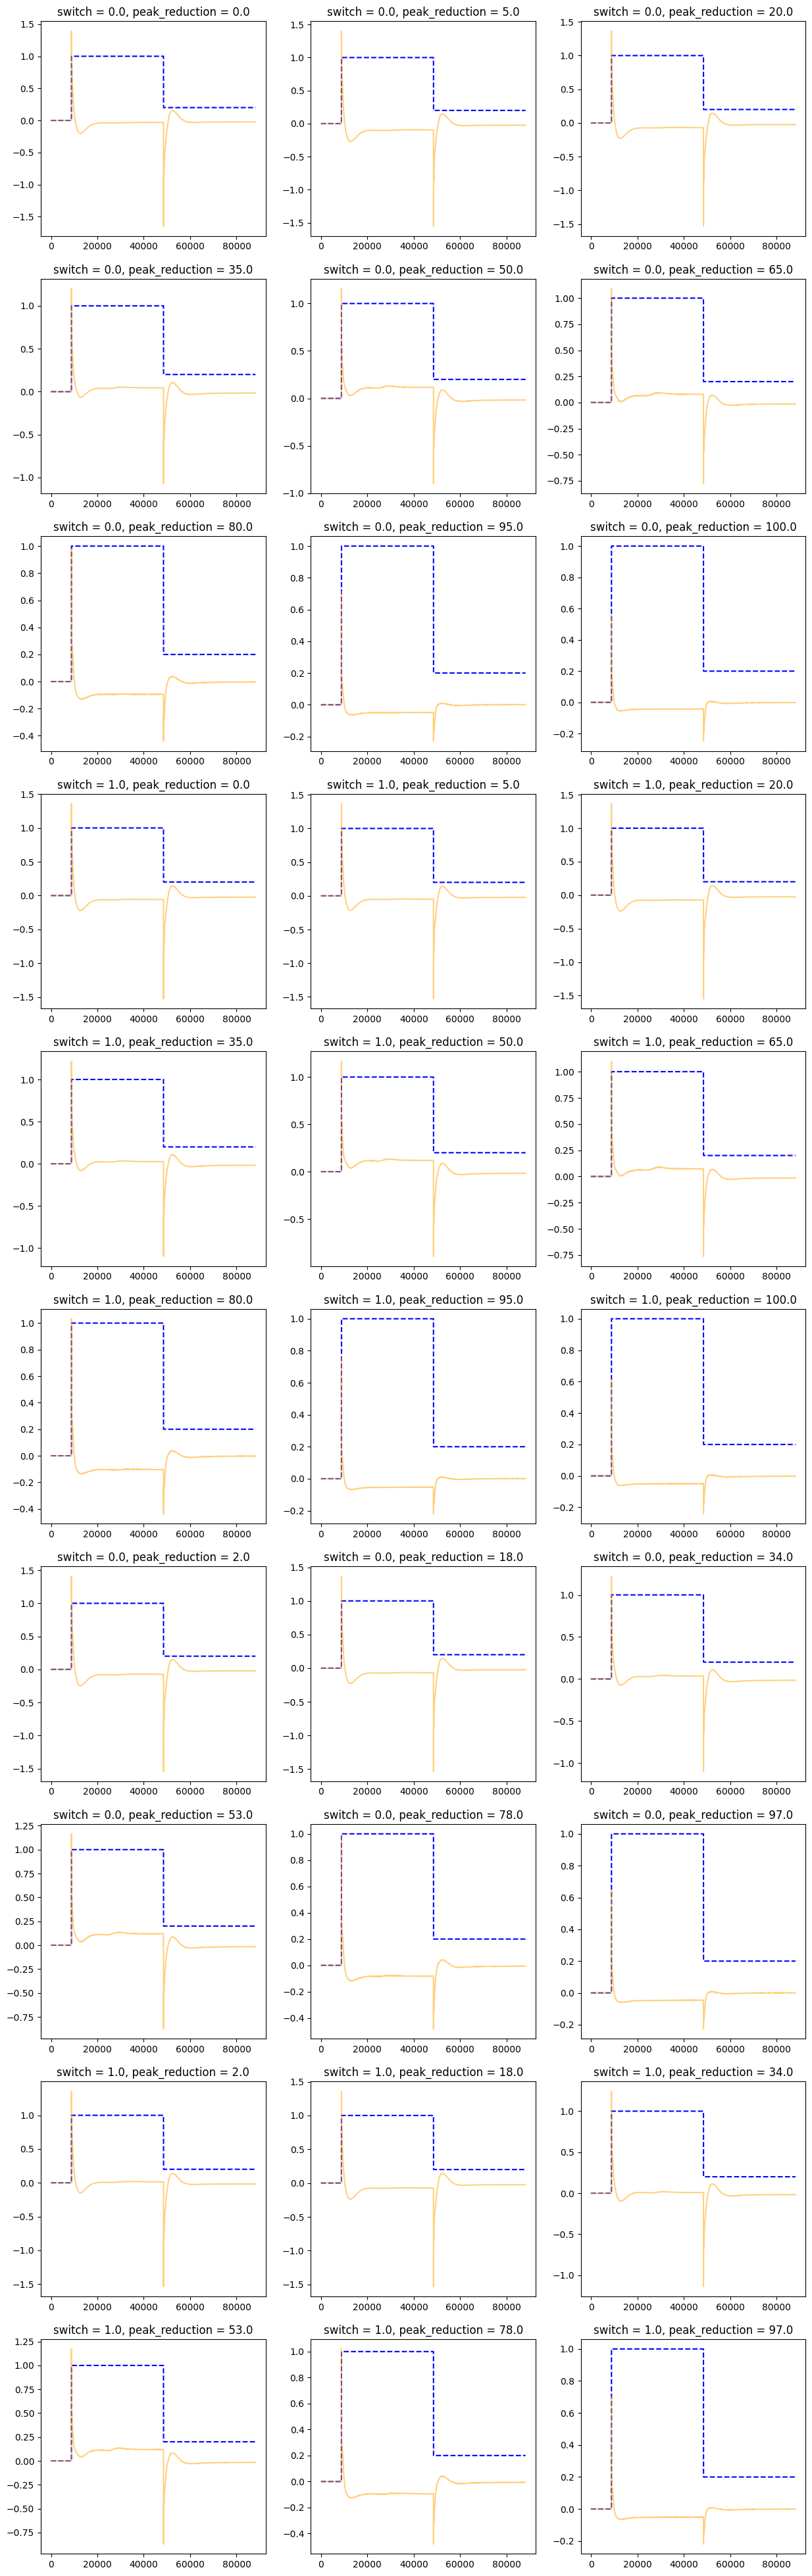

In [12]:
@torch.no_grad()
def evaluate_model_step_response():
    parameter_pair = torch.tensor([
        [0, 0],
        [0, 5],
        [0, 20],
        [0, 35],
        [0, 50],
        [0, 65],
        [0, 80],
        [0, 95],
        [0, 100],
        [1, 0],
        [1, 5],
        [1, 20],
        [1, 35],
        [1, 50],
        [1, 65],
        [1, 80],
        [1, 95],
        [1, 100],
        [0, 2],
        [0, 18],
        [0, 34],
        [0, 53],
        [0, 78],
        [0, 97],
        [1, 2],
        [1, 18],
        [1, 34],
        [1, 53],
        [1, 78],
        [1, 97],
    ]).to(device, torch.float32)
    
    sr = testing_dataset.sample_rate
    step_signal = torch.cat([
        torch.zeros(int(sr * 0.2)),
        torch.ones(int(sr * 0.9)),
        torch.zeros(int(sr * 0.9)) + 0.2
    ]).to(device, torch.float32)
    output_signal: Tensor = model(
        step_signal.repeat(parameter_pair.size(0), 1),
        parameter_pair,
    )
    
    fig, axs = plt.subplots(10, 3, figsize=(15, 50))
    for i, signal in enumerate(output_signal.split(1)):
        switch, peak_reduction = parameter_pair[i].tolist()
        row, col = divmod(i, 3)
        ax = axs[row][col]
        ax.plot(step_signal.cpu().numpy(), color='blue', linestyle='dashed', alpha=1.0)
        ax.plot(signal.flatten().cpu().numpy(), color='orange', linestyle='solid', alpha=0.5)
        ax.set_title(f'{switch = }, {peak_reduction = }')
    fig.show()
    
evaluate_model_step_response()